In [26]:
import kagglehub
path = kagglehub.dataset_download("ananysharma/diseasecotton" )
print("Dataset downloaded to:", path)

Using Colab cache for faster access to the 'diseasecotton' dataset.
Dataset downloaded to: /kaggle/input/diseasecotton


In [27]:
import os

base_path = "/kaggle/input/diseasecotton/data"

train_path = os.path.join(base_path, "train")
valid_path = os.path.join(base_path, "val")
test_path  = os.path.join(base_path, "test")

# List classes in training set
folders = os.listdir(train_path)
print("Classes found in training set:", folders)

Classes found in training set: ['fresh cotton plant', 'fresh cotton leaf', 'diseased cotton plant', 'diseased cotton leaf']


In [28]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam


In [29]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

In [30]:
from tensorflow.keras.applications.resnet50 import preprocess_input

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)



train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    valid_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    classes=sorted(train_generator.class_indices.keys()),
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=sorted(train_generator.class_indices.keys()),
    shuffle=False
)




Found 1951 images belonging to 4 classes.
Found 324 images belonging to 4 classes.
Found 18 images belonging to 4 classes.


In [31]:
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False


In [32]:
for layer in base_model.layers[-15:]:
    layer.trainable = True

In [33]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)


In [34]:
model.compile(
    optimizer=Adam(learning_rate=3e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,113,284 (91.98 MB)

 Trainable params: 6,045,956 (23.06 MB)

 Non-trainable params: 18,067,328 (68.92 MB)

In [35]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

class_weights = dict(enumerate(class_weights))


In [37]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    batch_size=16,
    class_weight=class_weights,

)



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 59s 698ms/step - accuracy: 0.3899 - loss: 1.3657 - val_accuracy: 0.7315 - val_loss: 0.6987
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 29s 472ms/step - accuracy: 0.7653 - loss: 0.6243 - val_accuracy: 0.8673 - val_loss: 0.4085
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 29s 475ms/step - accuracy: 0.8834 - loss: 0.3497 - val_accuracy: 0.9321 - val_loss: 0.2379
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 31s 505ms/step - accuracy: 0.9278 - loss: 0.2230 - val_accuracy: 0.9537 - val_loss: 0.1413
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 29s 469ms/step - accuracy: 0.9441 - loss: 0.1812 - val_accuracy: 0.9691 - val_loss: 0.0956
Epoch 6/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 30s 485ms/step - accuracy: 0.9591 - loss: 0.1358 - val_accuracy: 0.9691 - val_loss: 0.0864
Epoch 7/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 29s 470ms/step - accuracy: 0.9677 - loss: 0.1101 - val_accuracy: 0.9784 - val_loss: 0.0650
Epoch 8/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 29s 482ms/step - accuracy: 0.9600 - loss: 0.1086 - val_accu

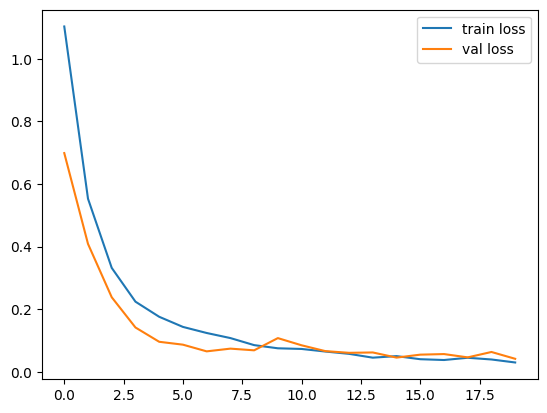

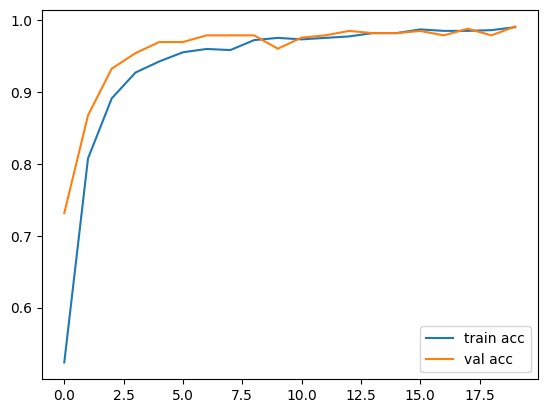

<Figure size 640x480 with 0 Axes>

In [38]:
import matplotlib.pyplot as plt
# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [39]:
model.save('resnet50_cotton_disease.h5')

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score
import seaborn as sns

In [41]:
y_pred=model.predict(test_generator)
y_pred=np.argmax(y_pred,axis=1)
y_true = test_generator.classes

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


In [42]:
class_labels = list(test_generator.class_indices.keys())

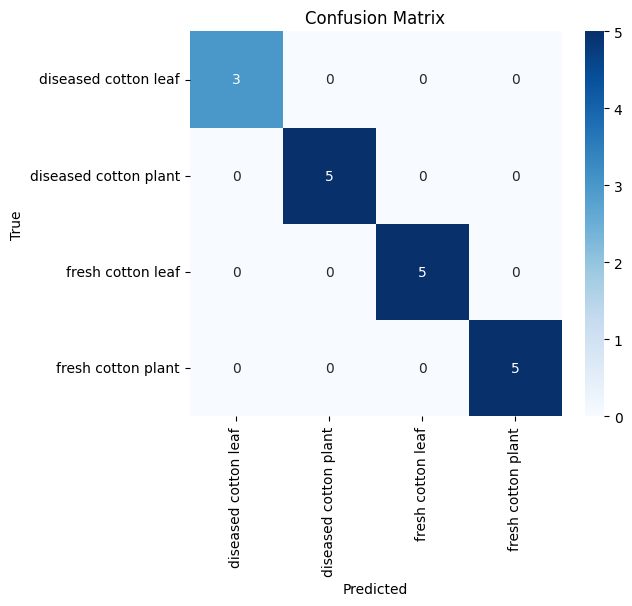

In [43]:
#Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [44]:
# Classification Report
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))


📊 Classification Report:
                       precision    recall  f1-score   support

 diseased cotton leaf       1.00      1.00      1.00         3
diseased cotton plant       1.00      1.00      1.00         5
    fresh cotton leaf       1.00      1.00      1.00         5
   fresh cotton plant       1.00      1.00      1.00         5

             accuracy                           1.00        18
            macro avg       1.00      1.00      1.00        18
         weighted avg       1.00      1.00      1.00        18



In [45]:
set(train_generator.filenames).intersection(set(val_generator.filenames))

set()